# Random Optimization Algorithms 

For a population based algorithm, we chose Evolutionary Strategies with a (μ+λ) approach,
and for a trajectory based algorithm we chose iterated local search.
# instances 

In [40]:
# get all instances fr m jobshop file

import parser.abz_parser as parser 
import random

with open("jobshop.txt", "r", encoding="utf-8") as f: 
  contents = f.read() 

instances = parser.parse_all_abz(contents)


# Algorithms 

## Trajectory 

In [41]:

from __future__ import annotations
from dataclasses import dataclass
import random
from typing import List, Optional, Protocol, Sequence, Tuple


class ThisType(Protocol):
    name: str
    n_jobs: int
    n_machines: int
    jobs: List[List[Tuple[int, int]]]


@dataclass
class ILSParams:
    iterations: int
    local_steps: int              #for ze hill climb steps per iteration
    swaps: int                    #how many random swaps
    seed: int
    accept_worse_prob: float      # probability to accept worse solutions
    verbose_every: int            # how often to print results 0 never
    init: str = "order"           # how to startinitial solution, order = job0,job1 and so on, while random is random lol


@dataclass
class ILSResults:
    best_sequence: List[int]      #list of the best jobs order
    best_makespan: int                #best finish time, total schedule length
    best_historically: List[int]  #best so far
    

# get total time from jobs in a set
def get_makespan(instance: ThisType, seq: list[int]):

    next_op       = [0]* instance.n_jobs
    job_ready     = [0]*instance.n_jobs
    machine_ready = [0]*instance.n_machines

    for s in seq:
        n = next_op[s]
        m, p = instance.jobs[s][n]

        start = machine_ready[m] if machine_ready[m] > job_ready[s] else job_ready[s]
        finish = start + p

        machine_ready[m] = finish
        job_ready[s] = finish
        next_op[s] = n + 1
    
    #print(f"job ready; {job_ready}, max job ready; {max(job_ready)}")
    return max(machine_ready)

# how many operations job do
def job_op_counts(instance: ThisType):
    return [len(instance.jobs[n]) for n in range(instance.n_jobs)]

# two initial states, we either take the jobshop list as is in order aka "order" or random aka "random"
def initial_state(instance: ThisType, rng: random.Random, method="order"):
    counts = job_op_counts(instance)
    total_ops = sum(counts)

    if method == "random":
        seq: List[int] = []

        for i, c in enumerate(counts):
            # instead of another for loop aka for _ in range(c) do seq.append(i). This way is faster.
            seq.extend([i]*c)
        rng.shuffle(seq)
        return seq

    # if order
    seq = []
    rem = counts[:]

    while len(seq) < total_ops:
        for i in range(instance.n_jobs):

            if rem[i] > 0:
                seq.append(i)
                rem[i] -= 1

    print(f"Sequence from initial_state: {seq}")
    return seq

# swao two neighbors
def random_swap(seq, rng):
    i, j = rng.sample(range(len(seq)), 2)
    return i, j


def apply_swap(seq, i, j):
    seq[i], seq[j] = seq[j], seq[i]


def local_search(instance: ThisType, seq, rng, steps):
    s = seq[:]  # copy current sequence
    s_cost = get_makespan(instance, s)

    for _ in range(steps):
        i, j = random_swap(s, rng)
        apply_swap(s, i, j)
        s_candidate_cost = get_makespan(instance, s)

        if s_candidate_cost <= s_cost:
            s_cost = s_candidate_cost
        else:
            apply_swap(s, i, j)

    return s


# helps escape local maximum depending on value of swaps
def escape_local(seq, rng, swaps: int):
    s = seq[:]
    for _ in range(swaps):
        i, j = random_swap(s, rng)
        apply_swap(s, i, j)
    return s

def iterated_local_search(instance: ThisType, params: ILSParams, initial=None):
    rng         = random.Random(params.seed)

    #initiate seaquence and search
    s0          = initial[:] if initial is not None else initial_state(instance,rng,method=params.init)
    s           = local_search(instance, s0, rng, steps=params.local_steps)

    best        = s[:]
    best_cost   = get_makespan(instance,best)
    history     = [best_cost]

    for i in range(1, params.iterations + 1):
        S_ESC   = escape_local(s,rng,params.swaps)
        S_NEW   = local_search(instance,S_ESC,rng, steps=params.local_steps)

        cost_s  = get_makespan(instance,s)
        cost_new= get_makespan(instance,S_NEW)

        #we acccept
        if cost_new < cost_s:
            s = S_NEW
        else:
            if params.accept_worse_prob > 0 and rng.random() < params.accept_worse_prob:
                s = S_NEW
        
        cost_s = get_makespan(instance,s)
        if cost_s < best_cost:
            best = s[:]
            best_cost = cost_s
        
        history.append(best_cost)

        if i % 10 == 0:
            print("current:", cost_s, "best:", best_cost)

        if params.verbose_every and (i % params.verbose_every == 0):
            print(f"[ILS] iter={it} current={cost_s} best={best_cost}")
        
    return ILSResults(best_sequence=best, best_makespan=best_cost, best_historically=history)


In [42]:
# test run of ILS algorithm 
inst = instances[5]
rand = 42 + random.randint(0, 1_000_000_000)
params = ILSParams(iterations=10, local_steps=10, swaps=7, seed=rand, accept_worse_prob=0.1, verbose_every=200, init="order")
res = iterated_local_search(inst, params)
job_ready = get_makespan(inst, res.best_sequence)
print("instance:", inst.name, inst.n_jobs, inst.n_machines)
print("best makespan:", res.best_makespan)
print("best job completion times:", job_ready)
    


Sequence from initial_state: [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]
current: 71 best: 57
instance: instance ft06 6 6
best makespan: 57
best job completion times: 57


## Population 

For the population based algorithm, we chose evolutionary strategies. 

The algorithm is designed such as a population of size lambda is randomly generated. 
Then, mu new genomes are created by random uniform selection of a parent from the previous population and then the mutation operation is applied. 
Lambda is a fixed value, set at 100 for this experiment, whereas mu will be adjusted according to Rechenberg's 1/5 success rule, such as mu will be incremented or decremented if more or less than 1/5 of new genomes outperform their parents. 
Then, the lambda best out of mu + lambda genomes "survive" and carry on to the next generation. 

For the final experiment, lambda is set to 100 and mu is set to 750, following the recommendation in [Introduction to Evolutionary Computation](https://link.springer.com/book/10.1007/978-3-662-44874-8), to set a ratio of lambda/mu greater than 7.

The mutation method used swaps places of two items in the array

In [43]:
from typing import List, Tuple
#######
# Genetic Strategy
# Encoding: There are n machines and m jobs, where each job has n stepshttps://scheduleopt.github.io/benchmarks/jsplib/#overview-of-the-jobshop-benchmark.
# Candidate solutions are represented by an ordered list of integers from
# 0 to m exclusive, where the i:th occurance of an integer j means that at that point,
# the i:th task of job j is performed.


def job_based_crossover(parent1: List[int], parent2: List[int], n_jobs: int):
    mask = random.choices([0, 1], k=n_jobs)
    mask_lookup = {i for i, val in enumerate(mask) if val == 1}
    offspring = [-1 for _ in range(len(parent1))]
    for i, val in enumerate(parent1):
        if val in mask_lookup:
            offspring[i] = val
    remaining_positions = [i for i, val in enumerate(offspring) if val == -1]
    current_pos = 0
    for val in parent2:
        if val not in mask_lookup:
            offspring[remaining_positions[current_pos]] = val
            current_pos += 1
    return offspring


def generate_random_genome(n_jobs: int, n_machines: int):
    res = []
    for _ in range(n_machines):
        res.extend(random.sample(range(n_jobs), n_jobs))
    for i in range(n_jobs):
        assert res.count(i) == n_machines, f"Expected {n_machines} occurances of i, got {res.count(i)}"
    return tuple(res)


# Generate a random population of size size.
# Stores generated genomes in a set to ensure uniqueness of candidate solutions
def generate_random_population(size: int, n_machines: int, n_jobs: int):
    genomes = set()

    current_size = 0
    while True:
        if current_size == size:
            break
        genome = generate_random_genome(n_machines, n_jobs)
        if genome not in genomes:
            current_size += 1
            genomes.add(genome)
    return list(genomes)


def mutate(genome: Tuple[int]):
    i, j = random.sample(range(len(genome)), 2)
    genome = list(genome)
    genome[i], genome[j] = genome[j], genome[i]
    return genome

# TODO:
# - Write generate random genome function
# - Score them using Deivids method
# - mu parents and lambda offspring
# - Implement the 1/5th rule to modify crossover rate
# - Run until convergence, i.e certain number of generations without improvement


class Population():
    def __init__(self, problem_instance: ThisType,
                  lambda_param: int = 100, 
                  mu_param: int = 750, 
                  max_iterations_without_improvement: int = 100,
                  new_genomes_per_gen: int = 50
                 ):
        self.problem_instance = problem_instance
        self.lambda_param = lambda_param 
        self.mu_param = mu_param
        self.population = generate_random_population(
            lambda_param, problem_instance.n_jobs, problem_instance.n_machines)
        self.max_iterations_without_improvement = max_iterations_without_improvement
        self.new_genomes_per_gen = new_genomes_per_gen
        self.history_best = []
    def simulate_generation(self):
        random.seed()
        current_idx = 0
        new_genomes = [] 
        no_better_children = 0 
        for i in range(self.mu_param):
            parent = random.choice(self.population)
            new_genome = mutate(parent)            
            new_genomes.append(new_genome)
            if get_makespan(self.problem_instance, new_genome) < get_makespan(self.problem_instance, parent):
                no_better_children += 1
        old_population = self.population.copy()
        self.population.extend(new_genomes)
        self.population.sort(key=lambda x: get_makespan(
            self.problem_instance, x))
        self.population = self.population[:self.lambda_param]
        old_population.sort(key=lambda x: get_makespan(self.problem_instance, x))

        # apply Rechenberg's 1/5 success rule
        if no_better_children > self.mu_param // 5:   
            self.mu_param += 1 
        elif no_better_children < self.mu_param // 5: 
            self.mu_param -= 1
    def simulation(self):
        current_gen = 0
        gens_without_improvement = 0
        best_score = float("inf")
        print("Starting run with instance", self.problem_instance.name)
        while True:
            self.simulate_generation()
            current_best_score = get_makespan(self.problem_instance, self.population[0])
            if current_best_score >= best_score:
                gens_without_improvement += 1
            else:
                best_score = current_best_score
                gens_without_improvement = 0
            if gens_without_improvement == self.max_iterations_without_improvement:
                break
            # best-so-far curve
            self.history_best.append(best_score)

        return best_score

In [44]:
# test run for evolutionary strategies 
population = Population(inst) 
best_result = population.simulation() 
print(best_result)



Starting run with instance instance ft06
55




## Evolutionary strategies 

We decided on using these 10 problem for our benchmarking: yn1, la37, la02, orb01, la30, ft06, la22, swv02, orb10, abz8. They are a good mix of "easy" and "medium" problems, as defined by [JSPLib](https://scheduleopt.github.io/benchmarks/jsplib/#overview-of-the-jobshop-benchmark) 


In [45]:
test_instances_names = ["yn1", "la37", "la02", "orb01", "la30", "ft06", "la22", "swv02", "orb10", "abz8"] 
test_instances = [] 
for instance in instances: 
    name = instance.name.split()[1] 
    if name in test_instances_names: 
        test_instances.append(instance) 

# Results 

For our final experiment, we ran each of our 10 problem instances 5 times each for both algorithms and compared the results. 



In [46]:
import matplotlib.pyplot as plt
global_results_ils = []
global_results_es = []
for instance in test_instances:
  results_ils = [] 
  results_es = [] 
  for i in range(5):
    rand = 42 + random.randint(0, 1_000_000_000)
    params = ILSParams(iterations=87, local_steps=200, swaps=2, seed=rand, accept_worse_prob=0.15, verbose_every=200, init="order")
    res = iterated_local_search(instance, params)
    job_ready = get_makespan(instance, res.best_sequence)
    results_ils.append(job_ready) 
    population = Population(problem_instance=inst, lambda_param=161, mu_param=444)
    population = Population(instance) 
    results_es.append(population.simulation())

  print("Instance:", instance.name)
  print(f"Best solution ils: {min(results_ils)}, best solution es: {min(results_es)}")
  print(f"Average ils: {sum(results_ils) / 5}, average es: {sum(results_es) / 5}")
  global_results_ils.append(min(results_ils))
  global_results_es.append(min(results_es))
plot_labels = [instance.name.split()[1] for instance in test_instances] 


Sequence from initial_state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

KeyboardInterrupt: 

['abz8', 'ft06', 'la02', 'la22', 'la30', 'la37', 'orb01', 'orb10', 'swv02', 'yn1']


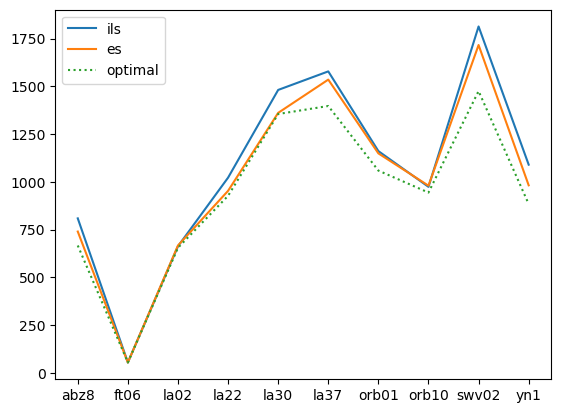

In [8]:
print(plot_labels)
plt.plot(plot_labels, global_results_ils, label="ils")
plt.plot(plot_labels, global_results_es, label="es")
optimal_solutions = [667, 55, 655, 927, 1355,1397,1059,944,1475,884]
plt.plot(plot_labels, optimal_solutions, linestyle="dotted",label="optimal",)
plt.legend()
plt.show()


The two algorithms perform very closely to each other, with evolution strategies narrowly beating out ILS in a few of the instances, and both algorithms very closely approach the optimal solutions.

The following code will demonstrate convergence for both algorithms, when running the la02 problem instance. 

Sequence from initial_state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
current: 687 best: 687
current: 677 best: 677
current: 766 best: 671
current: 714 best: 671
current: 686 best: 671
current: 681 best: 671
current: 753 best: 671
current: 695 best: 671
Sequence from initial_state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
current: 706 best: 706
current: 747 best: 706
current: 725 best: 706
current: 695 best: 695
current: 695 best: 695
current: 739 best: 682
current: 679 best: 679
current: 732 best: 679
Sequence from initial_state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
current: 739 best: 699
current: 710 best: 699
current: 750 best: 699
current: 713 best: 699


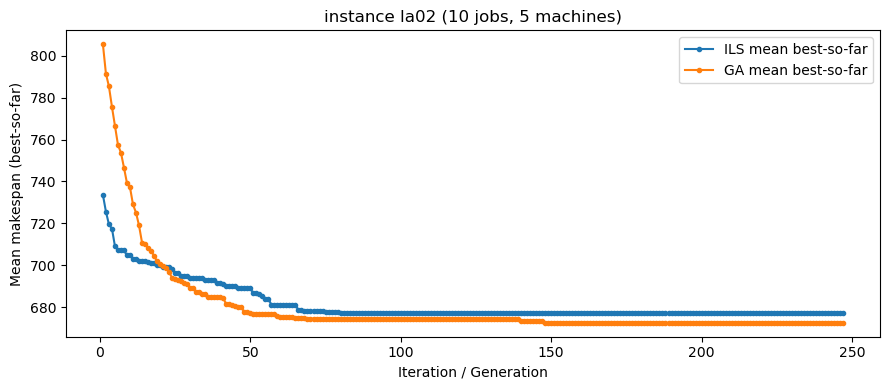

Saved: logs/convergence_inst31.png


In [20]:
import random
import statistics
import time
from dataclasses import asdict
from pathlib import Path


def _pad_to(hist, L):
    if not hist:
        return [0] * L
    return hist + [hist[-1]] * (L - len(hist))

def plot_convergence_mean(report, out_dir="logs", tag="conv"):
    out = Path(out_dir)
    out.mkdir(exist_ok=True)

    name, nj, nm = report["instance"]

    ils_h = report["ils"]["histories"]  # List[List[int]]
    ga_h  = report["ga"]["histories"]

    # Choose a common length (use max, pad shorter runs)
    L = max(max(len(h) for h in ils_h), max(len(h) for h in ga_h))

    ils_h = [_pad_to(h, L) for h in ils_h]
    ga_h  = [_pad_to(h, L) for h in ga_h]

    ils_mean = [sum(h[i] for h in ils_h) / len(ils_h) for i in range(L)]
    ga_mean  = [sum(h[i] for h in ga_h)  / len(ga_h)  for i in range(L)]

    xs = list(range(1, L + 1))

    plt.figure(figsize=(9, 4))
    plt.plot(xs, ils_mean, label="ILS mean best-so-far", marker="o", markersize=3)
    plt.plot(xs, ga_mean,  label="GA mean best-so-far",  marker="o", markersize=3)
    plt.xlabel("Iteration / Generation")
    plt.ylabel("Mean makespan (best-so-far)")
    plt.title(f"{name} ({nj} jobs, {nm} machines)")
    plt.legend()
    plt.tight_layout()

    p = out / f"convergence_{tag}.png"
    plt.show()

    plt.savefig(p, dpi=160)
    plt.close()
    print("Saved:", p)

# -----------------------
# Pick your defaults here
# -----------------------

DEFAULT_ILS_CFG = dict(
    iterations=87,
    local_steps=200, #low for fast
    swaps=2,
    accept_worse_prob=0.15,
    init="order",
    verbose_every=0,
)

DEFAULT_GA_CFG = dict(
    lambda_param=161,  #175
    mu_param=444,
    verbose_every=0,
)


# -----------------------
# Helpers
# -----------------------

def summarize(scores: List[float], runtime_sec: float) -> Dict[str, Any]:
    return {
        "n": len(scores),
        "mean": statistics.mean(scores),
        "median": statistics.median(scores),
        "min": min(scores),
        "max": max(scores),
        "stdev": statistics.pstdev(scores) if len(scores) > 1 else 0.0,
        "runtime_sec": runtime_sec,
    }


def pick_instance(instances, *, idx: Optional[int] = None, name: Optional[str] = None):
    if idx is not None:
        return instances[idx]
    if name is not None:
        for inst in instances:
            if inst.name == name:
                return inst
        raise ValueError(f"Instance name not found: {name}")
    return instances[0]


# -----------------------
# Solver runners
# -----------------------

def run_ils(inst, cfg, seed: int):
    params = ILSParams(
        iterations=cfg["iterations"],
        local_steps=cfg["local_steps"],
        swaps=cfg["swaps"],
        seed=seed,
        accept_worse_prob=cfg["accept_worse_prob"],
        verbose_every=cfg.get("verbose_every", 0),
        init=cfg["init"],
    )
    res = iterated_local_search(inst, params)
    # drop history[0] if it’s “iteration 0”
    return res.best_makespan, res.best_historically[1:]


def run_ga(inst, cfg, seed: int):
    random.seed(seed)
    pop = Population(
        problem_instance=inst,
        mu_param=cfg["mu_param"], 
        lambda_param=cfg["lambda_param"]
    )
    best = pop.simulation()
    return best, pop.history_best


def compare_on_instance(
    inst,
    *,
    ils_cfg: Dict[str, Any],
    ga_cfg: Dict[str, Any],
    repeats: int = 10,
    base_seed: int = 42,
):
    # generate deterministic seeds for fairness
    seeds = [base_seed + i for i in range(repeats)]
    ils_histories = []
    ga_histories = []

    # ---- ILS ----
    ils_scores: List[int] = []
    ils_best = (float("inf"), None, None)  # (score, seed, params)
    t0 = time.perf_counter()
    for sd in seeds:
        score, params = run_ils(inst, ils_cfg, sd)
        ils_scores.append(score)
        ils_histories.append(params)
        if score < ils_best[0]:
            ils_best = (score, sd, params)
    t1 = time.perf_counter()
    ils_stats = summarize([float(s) for s in ils_scores], t1 - t0)

    # ---- GA ----
    ga_scores: List[int] = []
    ga_best = (float("inf"), None, None)  # (score, seed, cfg)
    t2 = time.perf_counter()
    for sd in seeds:
        score, hist = run_ga(inst, ga_cfg, sd)
        ga_scores.append(score)
        ga_histories.append(hist)
        if score < ga_best[0]:
            ga_best = (score, sd, ga_cfg.copy())
    t3 = time.perf_counter()
    ga_stats = summarize([float(s) for s in ga_scores], t3 - t2)

    return {
        "instance": (inst.name, inst.n_jobs, inst.n_machines),
        "repeats": repeats,
        "seeds": seeds,
        "ils": {"cfg": ils_cfg, "scores": ils_scores, "histories": ils_histories, "stats": ils_stats, "best": ils_best},
        "ga":  {"cfg": ga_cfg,  "scores": ga_scores,  "histories": ga_histories,  "stats": ga_stats,  "best": ga_best},
    }


def compare_on_instances(
    instances,
    *,
    instance_indices: Optional[List[int]] = None,
    ils_cfg: Dict[str, Any],
    ga_cfg: Dict[str, Any],
    repeats: int = 10,
    base_seed: int = 42,
    per_instance_print: bool = True,
):
    if instance_indices is None:
        instance_indices = list(range(len(instances)))

    reports = []
    t0 = time.perf_counter()

    for k, idx in enumerate(instance_indices, start=1):
        inst = instances[idx]
        rep = compare_on_instance(
            inst,
            ils_cfg=ils_cfg,
            ga_cfg=ga_cfg,
            repeats=repeats,
            base_seed=base_seed,
        )
        reports.append(rep)

        if per_instance_print:
            print(f"[{k}/{len(instance_indices)}] {inst.name} done")

    t1 = time.perf_counter()

    # Each instance counts equally: aggregate using per-instance means
    ils_means = [r["ils"]["stats"]["mean"] for r in reports]
    ga_means  = [r["ga"]["stats"]["mean"] for r in reports]

    agg = {
        "n_instances": len(reports),
        "repeats": repeats,
        "total_runtime_sec": t1 - t0,
        "ils": {
            "mean_of_instance_means": statistics.mean(ils_means),
            "median_of_instance_means": statistics.median(ils_means),
        },
        "ga": {
            "mean_of_instance_means": statistics.mean(ga_means),
            "median_of_instance_means": statistics.median(ga_means),
        },
    }
    
    


    return reports, agg

def print_report(report: Dict[str, Any]):
    name, nj, nm = report["instance"]
    print(f"\n=== INSTANCE {name} ({nj} jobs, {nm} machines) ===")
    print(f"repeats: {report['repeats']} seeds: [{report['seeds'][0]}..{report['seeds'][-1]}]")

    # ILS
    ils = report["ils"]
    ils_stats = ils["stats"]
    ils_best_score, ils_best_seed, ils_best_params = ils["best"]
    print("\n--- ILS ---")
    print("cfg:", ils["cfg"])    # GA
    ga = report["ga"]
    ga_stats = ga["stats"]
    ga_best_score, ga_best_seed, ga_best_cfg = ga["best"]
    print("\n--- GA ---")
    print("cfg:", ga["cfg"])
    print("scores:", ga["scores"])
    print("stats:", {k: (round(v, 3) if isinstance(v, float) else v) for k, v in ga_stats.items()})
    print("best:", {"score": ga_best_score, "seed": ga_best_seed, "cfg": ga_best_cfg})


# -----------------------
# Main
# -----------------------

def main1():
    jobshop = open("jobshop.txt", "r", encoding="utf-8").read()
    instances = parse_all_abz(jobshop)
    for instance in instances: 
        if "la02" in instance.name.lower(): 
            inst = instance

    report = compare_on_instance(
        inst,
        ils_cfg=DEFAULT_ILS_CFG,
        ga_cfg=DEFAULT_GA_CFG,
        repeats=10,       # <- how many runs per solver
        base_seed=42,
    )

    print_report(report)

def main2():
    jobshop = open("jobshop.txt", "r", encoding="utf-8").read()
    instances = parser.parse_all_abz(jobshop)

    instance_indices = [31]  # run only instance #31
    for i, instance in enumerate(instances): 
        if "la02" in instance.name.lower(): 
            instance_indices = [i]

    reports, agg = compare_on_instances(
        instances,
        instance_indices=instance_indices,
        ils_cfg=DEFAULT_ILS_CFG,
        ga_cfg=DEFAULT_GA_CFG,
        repeats=10,
        base_seed=42,
        per_instance_print=False,
    )

    plot_convergence_mean(reports[0], out_dir="logs", tag="inst31")



main2()

Iteration length is normalized to match the longest running algorithm (typically ES). 
Based off of this, we see that the initial candidates for ILS start off significantly better than for ES, but ES catches up and keeps converging further after ILS has reached its stopping criteria. This is because ILS runs a certain number of iterations whereas the ES algorithm runs until a certain number of iterations has passed without the optimal solution improving. 

We haven't measured the runtime for these experiments, but since ILS runs for fewer iterations than ES it likely generates a viable solution faster than what ES will, whereas ES will most often generate a better solution than ILS. 

# Hackathon instance

In [ ]:
with open("jobshop_hackathon_instance_b.txt", "r") as f:
    contents = f.read()  

hackathon_instance = parse_all_abz(contents)[0]


rand = 42 + random.randint(0, 1_000_000_000)
params = ILSParams(iterations=87, local_steps=200, swaps=2, seed=rand, accept_worse_prob=0.15, verbose_every=200, init="order")
res = iterated_local_search(hackathon_instance, params)
job_ready = get_makespan(hackathon_instance, res.best_sequence)
population = Population(problem_instance=hackathon_instance, lambda_param=161, mu_param=444)
ge = population.simulation()
print(f"ils: {job_ready}, ge: {ge}")
 

Sequence from initial_state: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17